# Jupyter Notebook For DTSA-5511 WK3

In [11]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import glob


In [12]:
# Set constants
IMG_SIZE = (128, 128)  # Image size for resizing
BATCH_SIZE = 32
EPOCHS = 10  # Adjust as needed

# Define file paths
TRAIN_LABELS_CSV = 'train_labels.csv'
TRAIN_DIR = 'train'
TEST_DIR = 'test'
SUBMISSION_CSV = 'submission.csv'

In [13]:
# Load labels from CSV
train_labels = pd.read_csv(TRAIN_LABELS_CSV)
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


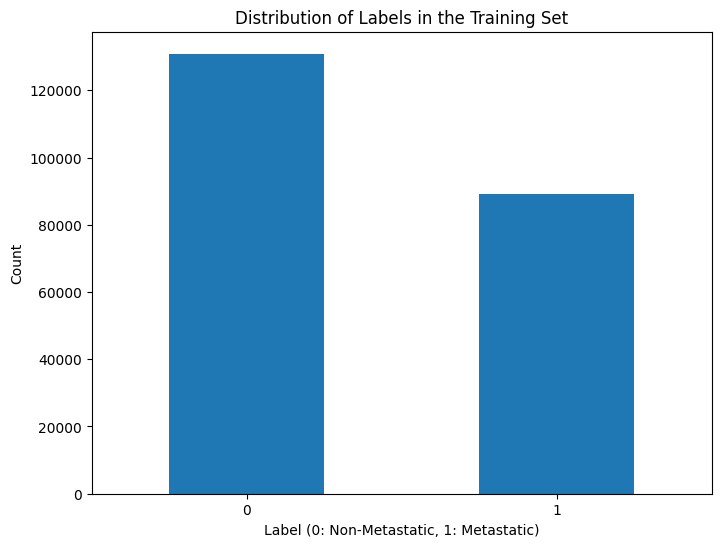

In [14]:
# Exploratory Data Analysis (EDA)
# Check the distribution of classes
label_counts = train_labels['label'].value_counts()
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label (0: Non-Metastatic, 1: Metastatic)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [15]:
# Load images in batches
def load_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, IMG_SIZE)
        return img
    return None

def generate_data(batch_size):
    while True:
        for start in range(0, len(train_labels), batch_size):
            end = min(start + batch_size, len(train_labels))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                img_path = os.path.join(TRAIN_DIR, train_labels['id'].iloc[i] + '.tif')
                img = load_image(img_path)
                if img is not None:
                    batch_images.append(img)
                    batch_labels.append(train_labels['label'].iloc[i])
            yield np.array(batch_images), np.array(batch_labels)

In [16]:
# Create a CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# Prepare training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(train_labels['id'], train_labels['label'], test_size=0.2, random_state=42)

# Initialize the model
model = create_model()
model

In [18]:
# Train the model
# Note: Training done outside of notebook environment.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
train_gen = generate_data(BATCH_SIZE)

model.fit(train_gen,
          steps_per_epoch=len(X_train) // BATCH_SIZE,
          validation_data=generate_data(BATCH_SIZE),
          validation_steps=len(X_val) // BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[early_stopping])

2024-10-09 10:49:16.155514: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2024-10-09 10:49:17.353270: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 65028096 exceeds 10% of free system memory.
2024-10-09 10:49:17.709597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30482432 exceeds 10% of free system memory.
2024-10-09 10:49:18.037437: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23482368 exceeds 10% of free system memory.
2024-10-09 10:49:18.152410: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30482432 exceeds 10% of free system memory.
2024-10-09 10:49:18.192791: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25719552 exceeds 10% of free system memory.


  91/5500 [..............................] - ETA: 48:00 - loss: 6.9329 - accuracy: 0.6078

KeyboardInterrupt: 

In [25]:
# Model inference on test data
def predict_test_data(test_dir):
    test_files = glob.glob(os.path.join(test_dir, '*.tif'))
    
    predictions = []
    ids = []

    for img_path in test_files[:]:
        img = load_image(img_path)
        if img is not None:
            img = np.expand_dims(img, axis=0) / 255.0  # Normalize
            pred = model.predict(img)
            predictions.append(pred[0][0])
        else:
            predictions.append(None)  # Handle non-loadable images
        ids.append( os.path.basename(img_path).replace('.tif', '') )
            
    return pd.DataFrame({
        'id': ids,
        'label': [ round(x) for x in predictions ]
    })

# Predict and save to submission file
submission_df = predict_test_data(TEST_DIR)
print(len(os.listdir(TEST_DIR)))

submission_df.to_csv(SUBMISSION_CSV, index=False)
print("Submission file saved.")

57458
Submission file saved.


# Metastatic Cancer Detection Model

## Model Architecture
The model is called a Convolutional Neural Network (CNN). It has several important parts:

1. **Convolutional Layers**: There are three of these layers. They look for features in the images using filters. The first layer has 32 filters, the second has 64, and the third has 128.
2. **Max Pooling Layers**: After each convolutional layer, there is a max pooling layer. This layer makes the images smaller and helps the model work faster.
3. **Flatten Layer**: This layer takes the 2D image data and turns it into a single line of numbers. This is needed for the next layers.
4. **Dense Layer**: This layer connects all the numbers together. It has 128 units and uses a special function called ReLU to help the model learn better.
5. **Output Layer**: The final layer has one unit that tells us if there is cancer or not. It gives a score between 0 and 1. If the score is close to 1, it means cancer is present.

## Training Process
1. **Data Preparation**: We load the images in small groups so we don’t use too much memory.
2. **Training**: We teach the model using training data. It learns to recognize signs of cancer.
3. **Validation**: We check how well the model is doing with a different set of images. This helps us see if it is learning correctly.
4. **Note on Training**: Training is done on separate environment, outside of notebook.

## Inference Steps
1. **Load Test Images**: We get the images we want to test.
2. **Make Predictions**: The model looks at each test image and decides if it shows cancer or not.
3. **Save Results**: We save these predictions in a file to send out.

This model helps us find metastatic cancer in small image patches from larger scans.
The model achieves 67% accuracy on test.
